In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error

In [102]:
base = pd.read_csv('bases/poluicao.csv')
base

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [103]:
base.isna().sum()

No          0
year        0
month       0
day         0
hour        0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64

In [104]:
base = base.dropna()

In [105]:
base.shape

(41757, 13)

In [106]:
base.columns

Index(['No', 'year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES',
       'cbwd', 'Iws', 'Is', 'Ir'],
      dtype='object')

In [107]:
base = base.drop(['No', 'year', 'month', 'day', 'hour'], axis=1)
base

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
24,129.0,-16,-4.0,1020.0,SE,1.79,0,0
25,148.0,-15,-4.0,1020.0,SE,2.68,0,0
26,159.0,-11,-5.0,1021.0,SE,3.57,0,0
27,181.0,-7,-5.0,1022.0,SE,5.36,1,0
28,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...
43819,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [108]:
ant = 40
predict = 10

In [109]:
base_test = base.iloc[base.shape[0] - predict:, :].values
base_test

array([[9.0, -27, 1.0, 1032.0, 'NW', 196.21, 0, 0],
       [11.0, -26, 1.0, 1032.0, 'NW', 205.15, 0, 0],
       [8.0, -23, 0.0, 1032.0, 'NW', 214.09, 0, 0],
       [9.0, -22, -1.0, 1033.0, 'NW', 221.24, 0, 0],
       [10.0, -22, -2.0, 1033.0, 'NW', 226.16, 0, 0],
       [8.0, -23, -2.0, 1034.0, 'NW', 231.97, 0, 0],
       [10.0, -22, -3.0, 1034.0, 'NW', 237.78, 0, 0],
       [10.0, -22, -3.0, 1034.0, 'NW', 242.7, 0, 0],
       [8.0, -22, -4.0, 1034.0, 'NW', 246.72, 0, 0],
       [12.0, -21, -3.0, 1034.0, 'NW', 249.85, 0, 0]], dtype=object)

In [110]:
base_test.shape

(10, 8)

In [111]:
base_train = base.iloc[base.shape[1]:base.shape[1] - ant, :].values
base_train

array([[120.0, -8, -6.0, ..., 12.51, 0, 0],
       [132.0, -7, -5.0, ..., 14.3, 0, 0],
       [140.0, -7, -5.0, ..., 17.43, 1, 0],
       ...,
       [73.0, -15, 6.0, ..., 6.71, 0, 0],
       [65.0, -14, 6.0, ..., 9.84, 0, 0],
       [55.0, -14, 6.0, ..., 11.63, 0, 0]], dtype=object)

In [112]:
base_train[:, 4]

array(['SE', 'SE', 'SE', ..., 'SE', 'SE', 'SE'], dtype=object)

In [113]:
le = LabelEncoder()
base_train[:, 4] = le.fit_transform(base_train[:, 4])

In [114]:
normalizer = MinMaxScaler(feature_range=(0, 1))
base_train_normalized = normalizer.fit_transform(base_train)

normalizerY = MinMaxScaler(feature_range=(0, 1))
normalizerY.fit_transform(base_train[:, 0:1])

array([[0.12072435],
       [0.13279678],
       [0.14084507],
       ...,
       [0.07344064],
       [0.06539235],
       [0.05533199]])

In [115]:
base_train_normalized

array([[0.12072435, 0.47058824, 0.21311475, ..., 0.02134362, 0.        ,
        0.        ],
       [0.13279678, 0.48529412, 0.2295082 , ..., 0.02451154, 0.        ,
        0.        ],
       [0.14084507, 0.48529412, 0.2295082 , ..., 0.03005097, 0.03703704,
        0.        ],
       ...,
       [0.07344064, 0.36764706, 0.40983607, ..., 0.01107886, 0.        ,
        0.        ],
       [0.06539235, 0.38235294, 0.40983607, ..., 0.01661829, 0.        ,
        0.        ],
       [0.05533199, 0.38235294, 0.40983607, ..., 0.01978621, 0.        ,
        0.        ]])

In [116]:
x_train = []
y_train = []
for i in range(ant, base_train_normalized.shape[0]):
    x_train.append(base_train_normalized[i-ant:i, 0:base_train.shape[1]])
    y_train.append(base_train_normalized[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [117]:
x_train.shape

(41677, 40, 8)

In [118]:
y_train.shape

(41677,)

In [119]:
model = Sequential()

model.add(Input((x_train.shape[1], x_train.shape[2])))

model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.3))
          
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.3))
          
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=50))
model.add(Dropout(0.3))

model.add(Dense(units=1, activation='linear'))

In [120]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 40, 100)        │        43,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 40, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 40, 50)         │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 40, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 40, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 40, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,251 (446.29 KB)

 Trainable params: 114,251 (446.29 KB)

 Non-trainable params: 0 (0.00 B)

In [121]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [122]:
early_stop = EarlyStopping(
    monitor='loss',
    patience=10,
    verbose=True
)

reduce_plateau = ReduceLROnPlateau(
    monitor='loss',
    factor=0.2,
    patience=5,
    verbose=1,
)

model_checkpoint = ModelCheckpoint(
    filepath='checkpoints/weights_poluicao.keras',
    monitor='loss',
    save_best_only=True,
    verbose=1
)

In [123]:
model.fit(x_train, y_train, epochs=100, batch_size=32, callbacks=[early_stop, reduce_plateau, model_checkpoint])

Epoch 1/100
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0041 - mean_absolute_error: 0.0442
Epoch 1: loss improved from inf to 0.00275, saving model to checkpoints/weights_poluicao.keras
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 108s 73ms/step - loss: 0.0041 - mean_absolute_error: 0.0442 - learning_rate: 0.0010
Epoch 2/100
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0014 - mean_absolute_error: 0.0247
Epoch 2: loss improved from 0.00275 to 0.00118, saving model to checkpoints/weights_poluicao.keras
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 141s 72ms/step - loss: 0.0014 - mean_absolute_error: 0.0247 - learning_rate: 0.0010
Epoch 3/100
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 8.9197e-04 - mean_absolute_error: 0.0198
Epoch 3: loss improved from 0.00118 to 0.00091, saving model to checkpoints/weights_poluicao.keras
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 94s 72ms/step - loss: 8.9198e-04 - mean_absolute_error: 0.0198 - learning_rate: 0.0010
Epoch 4/100
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/s

In [124]:
model.save('poluicao.keras')

In [125]:
model = tf.keras.models.load_model('poluicao.keras')

In [126]:
y_test = base.iloc[-predict:, 0].values
y_test

array([ 9., 11.,  8.,  9., 10.,  8., 10., 10.,  8., 12.])

In [127]:
len(base), len(base_test), len(base) - len(base_test) - ant

(41757, 10, 41707)

In [128]:
input = base[len(base) - len(base_test) - predict:].values
input.shape

(20, 8)

In [129]:
input = input[:, 0: 8]
input.shape

(20, 8)

In [130]:
input[:, 4] = le.transform(input[:, 4])

In [131]:
input = normalizer.transform(input)
input

array([[0.00804829, 0.30882353, 0.27868852, 0.70909091, 0.33333333,
        0.16689084, 0.        , 0.        ],
       [0.00905433, 0.27941176, 0.26229508, 0.70909091, 0.33333333,
        0.19379159, 0.        , 0.        ],
       [0.00804829, 0.25      , 0.24590164, 0.74545455, 0.33333333,
        0.22939969, 0.        , 0.        ],
       [0.00804829, 0.26470588, 0.2295082 , 0.78181818, 0.33333333,
        0.25233612, 0.        , 0.        ],
       [0.00804829, 0.26470588, 0.2295082 , 0.78181818, 0.33333333,
        0.26499009, 0.        , 0.        ],
       [0.00804829, 0.26470588, 0.26229508, 0.78181818, 0.33333333,
        0.27527255, 0.        , 0.        ],
       [0.00704225, 0.26470588, 0.27868852, 0.78181818, 0.33333333,
        0.28792652, 0.        , 0.        ],
       [0.01207243, 0.26470588, 0.27868852, 0.78181818, 0.33333333,
        0.30058049, 0.        , 0.        ],
       [0.01710262, 0.26470588, 0.31147541, 0.76363636, 0.33333333,
        0.31323446, 0.      

In [132]:
x_test = [input[i-predict:i, 0:8] for i in range(predict, input.shape[0])]
x_test = np.array(x_test)
x_test

array([[[0.00804829, 0.30882353, 0.27868852, 0.70909091, 0.33333333,
         0.16689084, 0.        , 0.        ],
        [0.00905433, 0.27941176, 0.26229508, 0.70909091, 0.33333333,
         0.19379159, 0.        , 0.        ],
        [0.00804829, 0.25      , 0.24590164, 0.74545455, 0.33333333,
         0.22939969, 0.        , 0.        ],
        [0.00804829, 0.26470588, 0.2295082 , 0.78181818, 0.33333333,
         0.25233612, 0.        , 0.        ],
        [0.00804829, 0.26470588, 0.2295082 , 0.78181818, 0.33333333,
         0.26499009, 0.        , 0.        ],
        [0.00804829, 0.26470588, 0.26229508, 0.78181818, 0.33333333,
         0.27527255, 0.        , 0.        ],
        [0.00704225, 0.26470588, 0.27868852, 0.78181818, 0.33333333,
         0.28792652, 0.        , 0.        ],
        [0.01207243, 0.26470588, 0.27868852, 0.78181818, 0.33333333,
         0.30058049, 0.        , 0.        ],
        [0.01710262, 0.26470588, 0.31147541, 0.76363636, 0.33333333,
         0.

In [133]:
x_test.shape

(10, 10, 8)

In [134]:
prevs = model.predict(x_test)
prevs

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[0.00510787],
       [0.0043796 ],
       [0.00798894],
       [0.00914055],
       [0.01041076],
       [0.01116868],
       [0.0079307 ],
       [0.00989571],
       [0.00936329],
       [0.00752922]], dtype=float32)

In [135]:
prevs = normalizerY.inverse_transform(prevs)
prevs

array([[ 5.0772247],
       [ 4.3533225],
       [ 7.941004 ],
       [ 9.085708 ],
       [10.348291 ],
       [11.101669 ],
       [ 7.883119 ],
       [ 9.836338 ],
       [ 9.307114 ],
       [ 7.484046 ]], dtype=float32)

In [136]:
prevs.shape, y_test.shape

((10, 1), (10,))

In [137]:
y_test.mean(), prevs.mean()

(9.5, 8.241784)

In [138]:
mean_absolute_error(y_test, prevs)

2.2267727851867676

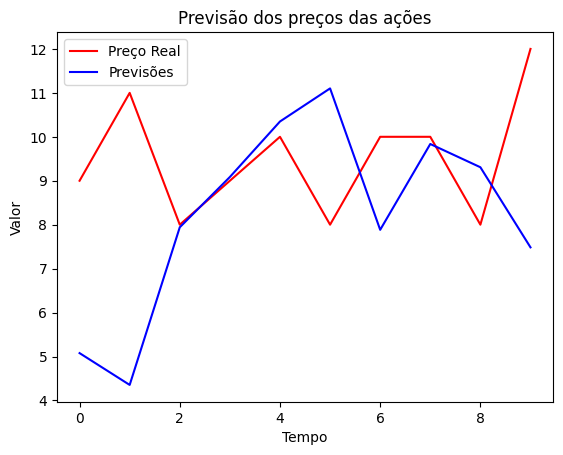

In [139]:
plt.plot(y_test, color='red', label='Preço Real')
plt.plot(prevs, color='blue', label='Previsões')
plt.title('Previsão dos preços das ações')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend();